In [73]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
from sklearn.utils import resample

In [ ]:
df = pd.read_csv("data/diabetic_data.csv")

# replacing ? with NaN
df = df.replace('?', np.nan)

df = df[df['readmitted'].isin(['<30', '>30', "NO"])]

# delete columns with more than 40% missing data
missing_threshold = 0.4
df = df.loc[:, df.isnull().mean() < missing_threshold]

# delete rows with missing values
df = df.dropna()

# Removing id and nbr
df = df.drop(['encounter_id', 'patient_nbr'], axis=1)

# Getting all categorical columns
categorical_cols = df.select_dtypes(include='object').columns.drop('readmitted')

# Doing one-hot encoding for the categorical columns, basically converting them to 0 or 1
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Setting readmitted to be 0, 1, or 2 based on class labels
df['readmitted'] = df['readmitted'].map({
    "NO": 0,
    "<30": 1,
    ">30": 2
})

# Keeping the original dataframe as well
original_df = df

print(f"Dataset shape after cleaning: {df.shape}")

Dataset shape after cleaning: (59129, 2163)


In [90]:
# Using random oversampling to adjust the data prior to working with it
print("Class distribution before balancing:")
print(df['readmitted'].value_counts())

# Getting index and number of the majority class in our dataset (Not readmitted)
majority = df['readmitted'].value_counts().idxmax()
majority_size = df['readmitted'].value_counts().max()

first_class = df[df["readmitted"] == 0]
second_class = df[df["readmitted"] == 1]
third_class = df[df["readmitted"] == 2]

# Using oversampling for both the minority classes
oversample_second_class = resample(second_class, replace=True, n_samples=majority_size, random_state=13)
oversample_third_class = resample(third_class, replace=True, n_samples=majority_size, random_state=13)

# Putting back the classes in to one dataframe and shuffling it
entire_dataframe = pd.concat([first_class, oversample_second_class, oversample_third_class])
entire_dataframe = entire_dataframe.sample(frac=1, random_state=13).reset_index(drop=True)
df = entire_dataframe

print("\nClass distribution after balancing:")
print(df['readmitted'].value_counts())

Class distribution before balancing:
readmitted
0    31457
2    21158
1     6514
Name: count, dtype: int64

Class distribution after balancing:
readmitted
1    31457
2    31457
0    31457
Name: count, dtype: int64


In [91]:
# Removing the readmitted column from the training data because we will use this to classify
X = df.drop("readmitted", axis=1)
y = df["readmitted"]


In [98]:
# Removing the readmitted column from the training data because we will use this to classify
original_X = original_df.drop("readmitted", axis=1)
original_y = original_df["readmitted"]

In [92]:
# Initially splitting the data with using 20% for testing
# We use a random state of 13 throughout for reproducibility
X_entire_train, X_test, y_entire_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

# Then, we split the remaining training data with 25% validation. 
# This way, we are using 20% of the entire data for validation and 60% for training.
X_train, X_val, y_train, y_val = train_test_split(X_entire_train, y_entire_train, test_size=0.25, random_state=13)

In [100]:
# Initially splitting the data with using 20% for testing
# We use a random state of 13 throughout for reproducibility
Xo_entire_train, Xo_test, yo_entire_train, yo_test = train_test_split(original_X, original_y, test_size=0.2, random_state=13)

# Then, we split the remaining training data with 25% validation. 
# This way, we are using 20% of the entire data for validation and 60% for training.
Xo_train, Xo_val, yo_train, yo_val = train_test_split(Xo_entire_train, yo_entire_train, test_size=0.25, random_state=13)

Best k: 1
Best k: 1
Best k: 1
Best k: 1
Best k: 1
Best k: 1
Best k: 1
Best k: 1
Best k: 1


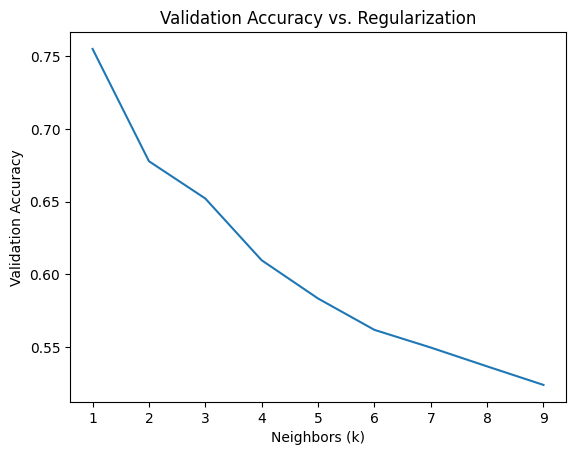

Best k: 1


In [80]:
# neighbors = range(11, 25)
neighbors = [1, 2, 3, 4, 5, 6, 7, 8, 9]
validation_acc = []

for neighbor in neighbors:
    knn = KNeighborsClassifier(n_neighbors=neighbor)
    knn.fit(X_train, y_train)
    accuracy = knn.score(X_val, y_val)
    validation_acc.append(accuracy)
    best_index = validation_acc.index(max(validation_acc))
    best_k = neighbors[best_index]
    print(f"Best k: {best_k}")

plt.plot(neighbors, validation_acc)
plt.title('Validation Accuracy vs. Regularization')
plt.xlabel('Neighbors (k)')
plt.ylabel('Validation Accuracy')
plt.show()

# Choose the best k
best_index = validation_acc.index(max(validation_acc))
best_k = neighbors[best_index]
print(f"Best k: {best_k}")

Best k: 100
Best k: 110
Best k: 120
Best k: 120
Best k: 120
Best k: 120
Best k: 120
Best k: 120
Best k: 120
Best k: 120
Best k: 120


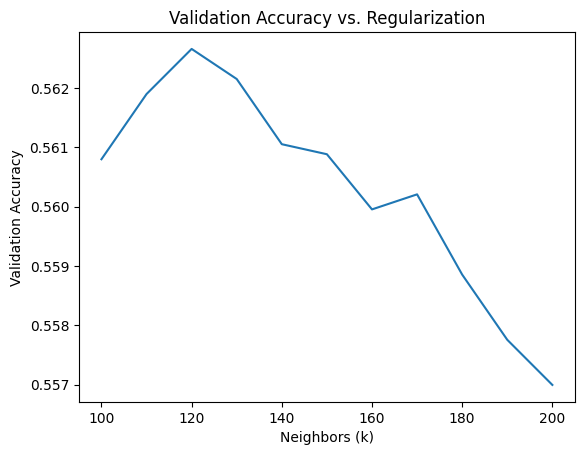

Best k: 120


In [101]:

neighbors = [100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]
validation_acc = []

for neighbor in neighbors:
    knn = KNeighborsClassifier(n_neighbors=neighbor)
    knn.fit(Xo_train, yo_train)
    accuracy = knn.score(Xo_val, yo_val)
    validation_acc.append(accuracy)
    best_index = validation_acc.index(max(validation_acc))
    best_k = neighbors[best_index]
    print(f"Best k: {best_k}")

plt.plot(neighbors, validation_acc)
plt.title('Validation Accuracy vs. Regularization')
plt.xlabel('Neighbors (k)')
plt.ylabel('Validation Accuracy')
plt.show()

# Choose the best k
best_index = validation_acc.index(max(validation_acc))
best_k = neighbors[best_index]
print(f"Best k: {best_k}")

In [ ]:
# Using k = 2 because 1 is too much overfitting
best_k = 2
knn_final = KNeighborsClassifier(n_neighbors=best_k)
knn_final.fit(X_entire_train, y_entire_train)
test_accuracy = knn_final.score(X_test, y_test)
print(f"Test Accuracy with best k={best_k}: {test_accuracy:.4f}")

Test Accuracy with best k=2: 0.7175


In [105]:
# Using k = 120 for the original data
best_ok = 120
knno_final = KNeighborsClassifier(n_neighbors=best_ok)
knno_final.fit(Xo_entire_train, yo_entire_train)
test_accuracy = knno_final.score(Xo_test, yo_test)
print(f"Test Accuracy with best k={best_ok}: {test_accuracy:.4f}")

Test Accuracy with best k=120: 0.5481


In [94]:
y_pred = knn_final.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[4313  853 1128]
 [ 277 5937   21]
 [2285  769 3292]]
              precision    recall  f1-score   support

           0       0.63      0.69      0.66      6294
           1       0.79      0.95      0.86      6235
           2       0.74      0.52      0.61      6346

    accuracy                           0.72     18875
   macro avg       0.72      0.72      0.71     18875
weighted avg       0.72      0.72      0.71     18875



In [107]:
yo_pred = knno_final.predict(Xo_test)
print(confusion_matrix(yo_test, yo_pred))
print(classification_report(yo_test, yo_pred))

[[5730    0  529]
 [ 969    0  313]
 [3530    3  752]]
              precision    recall  f1-score   support

           0       0.56      0.92      0.70      6259
           1       0.00      0.00      0.00      1282
           2       0.47      0.18      0.26      4285

    accuracy                           0.55     11826
   macro avg       0.34      0.36      0.32     11826
weighted avg       0.47      0.55      0.46     11826



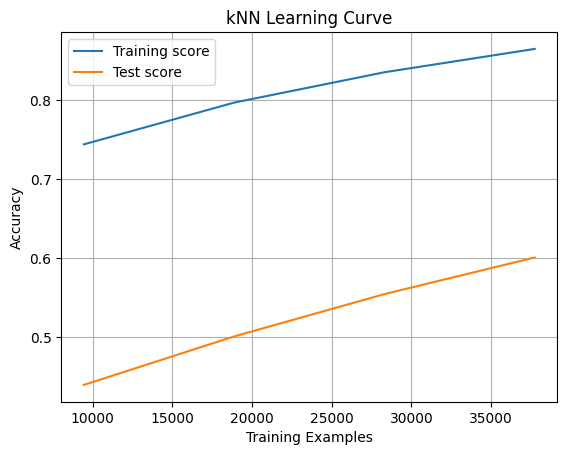

In [ ]:
train_sizes, train_scores, test_scores = learning_curve(
    knn_final, X, y, 
    cv=2, 
    scoring='accuracy', 
    train_sizes=[0.2, 0.4, 0.6, 0.8],
    n_jobs=1 
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure()
plt.plot(train_sizes, train_scores_mean, label="Training score")
plt.plot(train_sizes, test_scores_mean, label="Test score")
plt.title("kNN Learning Curve")
plt.xlabel("Training Examples")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

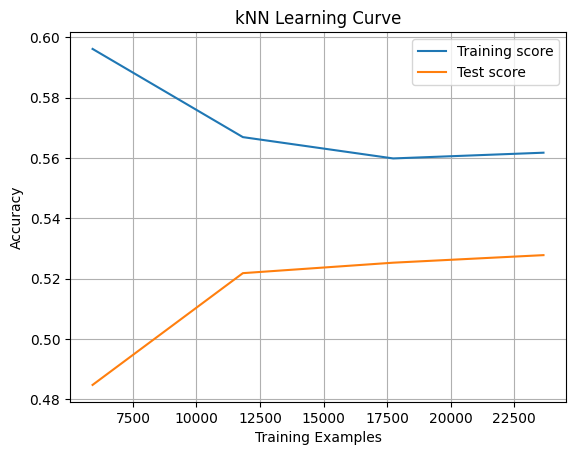

In [108]:
train_sizes, train_scores, test_scores = learning_curve(
    knno_final, original_X, original_y, 
    cv=2, 
    scoring='accuracy', 
    train_sizes=[0.2, 0.4, 0.6, 0.8],
    n_jobs=1 
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure()
plt.plot(train_sizes, train_scores_mean, label="Training score")
plt.plot(train_sizes, test_scores_mean, label="Test score")
plt.title("kNN Learning Curve")
plt.xlabel("Training Examples")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

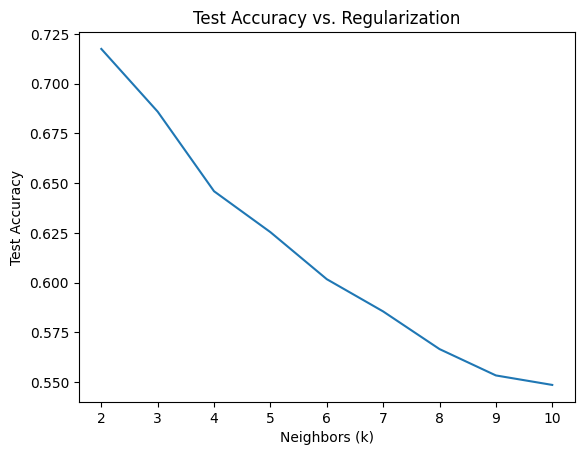

In [96]:
neighbors = [2, 3, 4, 5, 6, 7, 8, 9, 10]
test_acc = []

for neighbor in neighbors:
    knn = KNeighborsClassifier(n_neighbors=neighbor)
    knn.fit(X_entire_train, y_entire_train)
    y_test_pred = knn.predict(X_test)
    accuracy = accuracy_score(y_test, y_test_pred)
    test_acc.append(accuracy)

plt.plot(neighbors, test_acc)
plt.title('Test Accuracy vs. Regularization')
plt.xlabel('Neighbors (k)')
plt.ylabel('Test Accuracy')
plt.show()

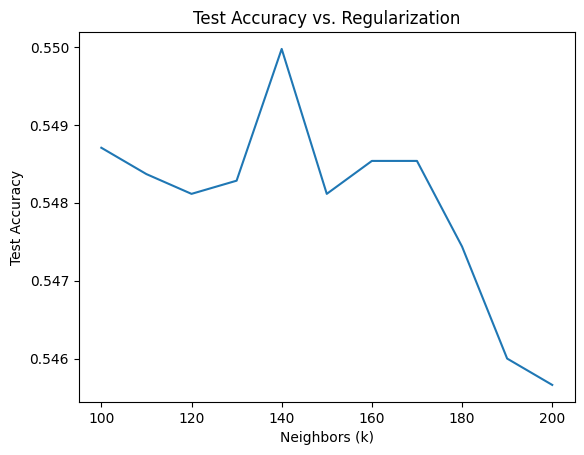

In [109]:
neighbors = [100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]
test_acc = []

for neighbor in neighbors:
    knn = KNeighborsClassifier(n_neighbors=neighbor)
    knn.fit(Xo_entire_train, yo_entire_train)
    y_test_pred = knn.predict(Xo_test)
    accuracy = accuracy_score(yo_test, y_test_pred)
    test_acc.append(accuracy)

plt.plot(neighbors, test_acc)
plt.title('Test Accuracy vs. Regularization')
plt.xlabel('Neighbors (k)')
plt.ylabel('Test Accuracy')
plt.show()